## Issues to check and Things to Do 

- **Log transformed** the features and see if they are linearly distributed in the log-log space. 
    - Examine the results for the data before and after the zeros have been dropped (relevant for the zeros heavy features, like the revenue). 
    - If the log transformation isn't the right transform, examine other transformation for long-tailed data. 
      
      
- **Kaggle feature engineering** [tutorial](https://www.kaggle.com/learn/feature-engineering) includes examples of using Kmeans and PCA and Mutual information that is exactly relevant to the analysis here -> Implement the examples there. 


- **Normality** of a given array is checked using the **Shapiro-Wilk** test. When running it on our data, there is a message that the p-value may not be accurate because N > 5000. That is, the test may not be accurate for large data-sets. 
    - I should check how this issue can be addressed. That is, the Shapiro-Wilk test appears to be the appropriate and best test to use for our data sets, so the questions is whether it has a variant that fits large data sets? whether there is a different test that is better suited for large data sets? and so on. 
    - From a simple look on our data, it is clearly not normal. So running the normality test can seem un-necessary. However, we won't be able to look at the datasets each time, and so there are two possible approached: 
        - assume the data is not normal
        - run a formal normality test. 
    - The latter approach is currently my favorite, and so dealing with this issue here. 
    - **Run Normality after the features have been log-transformed**. Before and after the zeros were dropped for each zero-governed feature (like the revenue features). Also, I am assuming the log is the relevant transformation, but it could be that a different transformation will be needed. 
       
       
- **Significance** - almost all pairs of features appears to be significantly correlated. It is not clear if this is indeed the case, or if the tests used are not suited to the data, or its amount (see point above about normality). 
    - I **need to look at the scatter plots** of the pairs and develop an idea on which correlations make sense to be significant, and which not. 
   
   
- **Correlograms** - to address the significance issue, I should prepare correlograms of the data so I can visualize the relations between the feature pairs and double check the relations between them. 

  
- **ADD Nominal** to the correlations estimation. 
    - Which test is for for Ordinal-Nominal?  
   
   
- **Mutual Information** - learn when MI is relevant here (e.g., is it relevant for numerical data only, or also for ordinal and/or nominal data as well? highly non-normal data? highly zero imbalanced data?) 
    - I think MI is for numerical and ordinal data. See the [Kaggle page](https://www.kaggle.com/learn/feature-engineering). 
    - It might also be relevant for the binary - ordinal. 
    - Probably not for the Nominal, but need to re-check this. 

  
- **Adapt** the correlation estimations function to run on **feature + Target**. 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
import time
import seaborn as sb

In [2]:
# Set Pandas to display more columns as default
pd.options.display.max_columns=30

In [3]:
def read_data_from_pickle(file_name, sort = True, by_column = 'dim_user_gid'): 
    
    data = pd.read_pickle(file_name)
    data["dim_user_gid"].astype(int)

    print("\nA short summary of the uploaded file:")
    print("The data was loaded into a data-frame.")
    print("There are {} different rows, and {} different columns.".format(data.shape[0], data.shape[1]))
    print("There are {} unique values at the dim_user_gid column.".format(data['dim_user_gid'].nunique()))
    print("There are {} *nan* values at the dim_user_gid column.".format(data['dim_user_gid'].isnull().sum()))

    if sort:
        data = data.sort_values(by = ["dim_user_gid"])
        print("The data-frame was sorted by the dim_user_gid column.\n")
    
    return data

# Bingo Blitz data - raw features set


### Available user properties + info for each

#### General comment: 
For data sets that span a long period of time (months, years), it is assumed that the criterions for a given feature are updated retroactively. For example, if the definition of the level brackets update, all users are re-cast into the new level brackets, even those that haven't played the app from before the new definition took place.  


- **top_platform**:
    - Nominal variable 
    - 7 different categories
    - Zero value at a given category are informative
    
- **level**: 
    - Numerical, discrete variable
    - Values from 1 to maximal level a user in a specific set achieved
    - No zero values (as any user begins with at least level 1)
    
- **trstier**:
    - Ordinal variable
    - Values of 1 to 7
    - No zero values (as any user begins with at least tier 1)
    
- **level_bracket**: 
    - Ordinal variable 
    - There are ten different brackets (can transform them from strings to values of 1 to 10 for simplicity purposes)
    - No zero values (as any user begins with at least the lowest level bracket of lv_01_07)
    
- **is_elite**:
    - Binary Ordinal variable 
    - Two different values
    - Zero value at a given category are informative (e.g., it could be that at a given data-set no users are in the elite category) 
    
- **is_vip**:
    - Binary Ordinal variable 
    - Two different values
    - Zero value at a given category are informative (e.g., it could be that at a given data-set no users are in the elite category) 
    
- **llrecency** (the last time the user was seen):
    - Numerical, discrete variable 
    - Values from 1 to the maximal recency of the users in the specific data set 
    - No zero values (each user has a value, with the minimal one being 1, that is, that user has been seen the day before the data set refers to)
    
- **Lifetime_Revenue_Net**:
    - Numerical, continous variable
    - Majority of values are zero, all are informative
    
- **Last_30D_Revenue_Net**:
    - Numerical, continous variable
    - Majority of values are zero, of which only those for users with recency <= 30 are informative
    
- **Last_90D_Revenue_Net**:
    - Numerical, continous variable
    - Majority of values are zero, of which only those for users with recency <= 90 are informative
    
- **Last_30D_Transactions**:
    - Numerical, discrete variable 
    - Values from 0 to 30
    - Majority of values are zero, of which only those for users with recency <= 30 are informative

- **Last_30D_Gross_Sink**:
    - Numerical, continous variable
    - Majority of values are zero, of which only those for users with recency <= 30 are informative

- **Last_90D_Gross_Sink**:
    - Numerical, continous variable
    - Majority of values are zero, of which only those for users with recency <= 90 are informative
    
- **Life_Time_Login_Days**:
    - Numerical, discrete variable 
    - Values from 0 to 4000 
    - No zeros (at least 1 login day for each user)

- **Last_30D_Login_days**:
    - Numerical, discrete variable 
    - Values from 0 to 30
    - Majority of values are zero, informative
    
- **Last_90D_Login_days**:
    - Numerical, discrete variable 
    - Values from 0 to 90
    - Majority of values are zero, informative
    
- **credits_balance_EOD**:
    - Numerical, continous variable (it is in fact a discrete variable, but as it spans such a wide range of values, it can be considered as continous)
    - Almost no zero values.
    
- **coins_balance_EOD**: 
    - Numerical, continous variable (it is in fact a discrete variable, but as it spans such a wide range of values, it can be considered as continous)
    - Almost no zero values.

- **number_of_bingo_rounds**:
    - Numerical, discrete variable 
    - Values from 0 to 433
    - Majority of values are zero, informative 
      
- **total_rounds_mode_1**:
    - Numerical, discrete variable 
    - Values from 0 to ca. 300 
    - Majority of values are zero, informative 
      
- **total_rounds_mode_2**:
    - Numerical, discrete variable 
    - Values from 0 to ca. 300 
    - Majority of values are zero, informative 

- **total_rounds_mode_3**:
    - Numerical, discrete variable 
    - Values from 0 to ca. 300 
    - Majority of values are zero, informative 

- **total_rounds_mode_4**:
    - Numerical, discrete variable 
    - Values from 0 to ca. 300 
    - Majority of values are zero, informative 

- **total_rounds_mode_5**:
    - Numerical, discrete variable 
    - Values from 0 to ca. 300
    - Majority of values are zero, informative 

- **total_rounds_mode_6**:
    - Numerical, discrete variable 
    - Values from 0 to ca. 300 
    - Majority of values are zero, informative 

In [4]:
recency_30D_features = ['Last_30D_Revenue_Net', 'Last_30D_Transactions', 'Last_30D_Gross_Sink']
recency_90D_features = ['Last_90D_Revenue_Net', 'Last_90D_Gross_Sink']

recency_dependent_features = {}
recency_dependent_features.update({'30D': recency_30D_features})
recency_dependent_features.update({'90D': recency_90D_features})

## Loading the data and important cleaning steps

In [5]:
# # Data with 1 million users
# file_name = "Data/data_features_1_million_users_20220915.pkl"

# Data with 5 million users
file_name = "Data/data_features_5_million_users_20220915.pkl"

In [6]:
data_for_clustering = read_data_from_pickle(file_name)
data_for_clustering.head(10)


A short summary of the uploaded file:
The data was loaded into a data-frame.
There are 5000000 different rows, and 26 different columns.
There are 5000000 unique values at the dim_user_gid column.
There are 0 *nan* values at the dim_user_gid column.
The data-frame was sorted by the dim_user_gid column.



,dim_user_gid,top_platform,level,trstier,level_bracket,is_elite,is_vip,llrecency,Lifetime_Revenue_Net,Last_30D_Revenue_Net,Last_90D_Revenue_Net,Last_30D_Transactions,Last_30D_Gross_Sink,Last_90D_Gross_Sink,Last_30D_Login_days,Last_90D_Login_days,credits_balance_EOD,coins_balance_EOD,number_of_bingo_rounds,Life_Time_Login_Days,total_rounds_mode_1,total_rounds_mode_2,total_rounds_mode_3,total_rounds_mode_4,total_rounds_mode_5,total_rounds_mode_6
23899,261,Apple,74.0,2.0,lv_40_79,0,0,4,0.0000,0.0000,0.0000,0,42.0000,42.0000,2,2,23992.0,989739.0,0,72,0,0,0,0,0,0
40151,288,Google,77.0,1.0,lv_40_79,0,0,1,0.0000,0.0000,0.0000,0,0.0000,0.0000,6,17,591.0,129887.0,0,66,0,0,0,0,0,0
40152,312,Google,97.0,1.0,lv_80_119,0,0,1,0.0000,0.0000,0.0000,0,16952.0000,53355.0000,29,89,279.0,485502.0,10,136,0,0,5,0,0,0
40153,376,Google,126.0,3.0,lv_120_139,0,0,10,85.1555,0.0000,10.4930,0,0.0000,2652.0000,1,7,2278.0,2863137.0,0,306,0,0,0,0,0,0
68592,381,Google,129.0,2.0,lv_120_139,0,0,1,110.9604,0.0000,10.4930,0,450.0000,25135.0000,10,36,5698.0,1277645.0,0,307,0,0,0,0,0,0
80781,388,Apple,85.0,2.0,lv_80_119,0,0,121,3.8430,0.0000,0.0000,0,0.0000,0.0000,0,0,1414.0,4238.0,0,109,0,0,0,0,0,0
48277,391,Web,243.0,2.0,lv_200plus,0,0,1,0.0000,0.0000,0.0000,0,11580.0000,34815.0000,30,90,4.0,4128.0,5,2480,5,0,0,0,0,0
3584,427,Facebook,208.0,3.0,lv_200plus,0,0,1,0.0000,0.0000,0.0000,0,21180.0000,238137.0000,27,87,426.0,9904.0,5,1164,0,0,0,0,0,0
48278,436,Facebook,72.0,2.0,lv_40_79,0,0,41,0.0000,0.0000,0.0000,0,0.0000,772.0000,0,1,204.0,342700.0,0,165,0,0,0,0,0,0
68593,454,Google,64.0,2.0,lv_40_79,0,0,49,0.0000,0.0000,0.0000,0,0.0000,1944.0000,0,1,207.0,25913.0,0,66,0,0,0,0,0,0


In [7]:
# Casting the numerical variables that are registered as 'object' into a float type
data_for_clustering['Lifetime_Revenue_Net'] = data_for_clustering['Lifetime_Revenue_Net'].astype(float)
data_for_clustering['Last_30D_Revenue_Net'] = data_for_clustering['Last_30D_Revenue_Net'].astype(float)
data_for_clustering['Last_90D_Revenue_Net'] = data_for_clustering['Last_90D_Revenue_Net'].astype(float)
data_for_clustering['Last_30D_Gross_Sink'] = data_for_clustering['Last_30D_Gross_Sink'].astype(float)
data_for_clustering['Last_90D_Gross_Sink'] = data_for_clustering['Last_90D_Gross_Sink'].astype(float)

data_for_clustering.dtypes

dim_user_gid                int64
top_platform               object
level                     float64
trstier                   float64
level_bracket              object
is_elite                    int64
is_vip                      int64
llrecency                   int64
Lifetime_Revenue_Net      float64
Last_30D_Revenue_Net      float64
Last_90D_Revenue_Net      float64
Last_30D_Transactions       int64
Last_30D_Gross_Sink       float64
Last_90D_Gross_Sink       float64
Last_30D_Login_days         int64
Last_90D_Login_days         int64
credits_balance_EOD       float64
coins_balance_EOD         float64
number_of_bingo_rounds      int64
Life_Time_Login_Days        int64
total_rounds_mode_1         int64
total_rounds_mode_2         int64
total_rounds_mode_3         int64
total_rounds_mode_4         int64
total_rounds_mode_5         int64
total_rounds_mode_6         int64
dtype: object

In [8]:
# Finding if there are null values at any of the columns
columns_with_nan = data_for_clustering.columns[data_for_clustering.isna().any()].tolist()
print(columns_with_nan)

['level', 'trstier', 'credits_balance_EOD', 'coins_balance_EOD']


In [9]:
# Finding how many nan values are there in the columns with such values:  
for col in columns_with_nan:
    print("There are {} nan values in the column {}.\n".format(data_for_clustering[col].isnull().sum(), col))

There are 8432 nan values in the column level.

There are 20 nan values in the column trstier.

There are 6218 nan values in the column credits_balance_EOD.

There are 6256 nan values in the column coins_balance_EOD.



In [10]:
# Finding how many rows has at least one nan value:
print(len(data_for_clustering) - len(data_for_clustering.dropna()))

14703


In [11]:
# As there are only ca. 15k lines, out of a total of 5000k lines, with nan values, and as the number of users 
# that are in both the raw data set and the targets sets is not decreased by too much when this rows are dropped, 
# I will just drop these lines with the nan values for now (instead of doing something more specific, like fill
# cells with nan with some mean value, etc.)
data_for_clustering.dropna(inplace = True)
data_for_clustering.shape

(4985297, 26)

## Setting the mathematical data type of each column

In [12]:
columns_names = data_for_clustering.columns.tolist()
columns_names.remove('dim_user_gid')

columns_math_data_types = {}
for column in columns_names:
    columns_math_data_types.update({column: ''})

In [13]:
columns_math_data_types.update({'top_platform': 'Nominal'})
columns_math_data_types.update({'level': 'Numerical'})
columns_math_data_types.update({'trstier': 'Ordinal'})
columns_math_data_types.update({'level_bracket': 'Ordinal'})
columns_math_data_types.update({'is_elite': 'Binary Ordinal'})
columns_math_data_types.update({'is_vip': 'Binary Ordinal'})

columns_math_data_types.update({'llrecency': 'Numerical'})
columns_math_data_types.update({'Lifetime_Revenue_Net': 'Numerical'})
columns_math_data_types.update({'Last_30D_Revenue_Net': 'Numerical'})
columns_math_data_types.update({'Last_90D_Revenue_Net': 'Numerical'})
columns_math_data_types.update({'Last_30D_Transactions': 'Numerical'})
columns_math_data_types.update({'Last_30D_Gross_Sink': 'Numerical'})

columns_math_data_types.update({'Last_90D_Gross_Sink': 'Numerical'})
columns_math_data_types.update({'Last_30D_Login_days': 'Numerical'})
columns_math_data_types.update({'Last_90D_Login_days': 'Numerical'})
columns_math_data_types.update({'credits_balance_EOD': 'Numerical'})
columns_math_data_types.update({'coins_balance_EOD': 'Numerical'})
columns_math_data_types.update({'number_of_bingo_rounds': 'Numerical'})

columns_math_data_types.update({'Life_Time_Login_Days': 'Numerical'})
columns_math_data_types.update({'total_rounds_mode_1': 'Numerical'})
columns_math_data_types.update({'total_rounds_mode_2': 'Numerical'})
columns_math_data_types.update({'total_rounds_mode_3': 'Numerical'})
columns_math_data_types.update({'total_rounds_mode_4': 'Numerical'})
columns_math_data_types.update({'total_rounds_mode_5': 'Numerical'})
columns_math_data_types.update({'total_rounds_mode_6': 'Numerical'})

columns_math_data_types

{'top_platform': 'Nominal',
 'level': 'Numerical',
 'trstier': 'Ordinal',
 'level_bracket': 'Ordinal',
 'is_elite': 'Binary Ordinal',
 'is_vip': 'Binary Ordinal',
 'llrecency': 'Numerical',
 'Lifetime_Revenue_Net': 'Numerical',
 'Last_30D_Revenue_Net': 'Numerical',
 'Last_90D_Revenue_Net': 'Numerical',
 'Last_30D_Transactions': 'Numerical',
 'Last_30D_Gross_Sink': 'Numerical',
 'Last_90D_Gross_Sink': 'Numerical',
 'Last_30D_Login_days': 'Numerical',
 'Last_90D_Login_days': 'Numerical',
 'credits_balance_EOD': 'Numerical',
 'coins_balance_EOD': 'Numerical',
 'number_of_bingo_rounds': 'Numerical',
 'Life_Time_Login_Days': 'Numerical',
 'total_rounds_mode_1': 'Numerical',
 'total_rounds_mode_2': 'Numerical',
 'total_rounds_mode_3': 'Numerical',
 'total_rounds_mode_4': 'Numerical',
 'total_rounds_mode_5': 'Numerical',
 'total_rounds_mode_6': 'Numerical'}

## How many zeros and overlapping zeros are there

In [14]:
# Dropping the columns that are categorical, binary, or ordinal discrete 
df_for_zero_counts = data_for_clustering.drop(['Life_Time_Login_Days'], axis = 1)
df_for_zero_counts.drop(df_for_zero_counts.iloc[:, 0:8], inplace=True, axis=1)
print(df_for_zero_counts.shape)
df_for_zero_counts.head(5)

(4985297, 17)


,Lifetime_Revenue_Net,Last_30D_Revenue_Net,Last_90D_Revenue_Net,Last_30D_Transactions,Last_30D_Gross_Sink,Last_90D_Gross_Sink,Last_30D_Login_days,Last_90D_Login_days,credits_balance_EOD,coins_balance_EOD,number_of_bingo_rounds,total_rounds_mode_1,total_rounds_mode_2,total_rounds_mode_3,total_rounds_mode_4,total_rounds_mode_5,total_rounds_mode_6
23899,0.0000,0.0,0.000,0,42.0,42.0,2,2,23992.0,989739.0,0,0,0,0,0,0,0
40151,0.0000,0.0,0.000,0,0.0,0.0,6,17,591.0,129887.0,0,0,0,0,0,0,0
40152,0.0000,0.0,0.000,0,16952.0,53355.0,29,89,279.0,485502.0,10,0,0,5,0,0,0
40153,85.1555,0.0,10.493,0,0.0,2652.0,1,7,2278.0,2863137.0,0,0,0,0,0,0,0
68592,110.9604,0.0,10.493,0,450.0,25135.0,10,36,5698.0,1277645.0,0,0,0,0,0,0,0


In [15]:
num_of_users = df_for_zero_counts.shape[0]
zeros = []
for column in df_for_zero_counts:
    zeros.append(len(df_for_zero_counts[df_for_zero_counts[column] == 0]))
    print("\nThere are {} *zeros* at the column {}.".format(zeros[-1], column))
    print("This is {:.2f}% of the users in the list.\n".format(zeros[-1]/num_of_users*100))


There are 4190866 *zeros* at the column Lifetime_Revenue_Net.
This is 84.06% of the users in the list.


There are 4723048 *zeros* at the column Last_30D_Revenue_Net.
This is 94.74% of the users in the list.


There are 4619599 *zeros* at the column Last_90D_Revenue_Net.
This is 92.66% of the users in the list.


There are 4723046 *zeros* at the column Last_30D_Transactions.
This is 94.74% of the users in the list.


There are 3667571 *zeros* at the column Last_30D_Gross_Sink.
This is 73.57% of the users in the list.


There are 3161994 *zeros* at the column Last_90D_Gross_Sink.
This is 63.43% of the users in the list.


There are 3482986 *zeros* at the column Last_30D_Login_days.
This is 69.87% of the users in the list.


There are 2865639 *zeros* at the column Last_90D_Login_days.
This is 57.48% of the users in the list.


There are 34954 *zeros* at the column credits_balance_EOD.
This is 0.70% of the users in the list.


There are 591 *zeros* at the column coins_balance_EOD.
This i

In [16]:
mat_zeros_overlap_count = np.zeros([df_for_zero_counts.shape[1], df_for_zero_counts.shape[1]])

for column_i in df_for_zero_counts:
    i = df_for_zero_counts.columns.get_loc(column_i)
    for column_j in df_for_zero_counts:
        j = df_for_zero_counts.columns.get_loc(column_j)
        mat_zeros_overlap_count[i][j] = len(df_for_zero_counts.query('{} == 0 and {} == 0'.format(column_i, column_j)))/df_for_zero_counts.shape[0]

In [17]:
zeros_asarray = np.asarray([ele/df_for_zero_counts.shape[0] for ele in zeros])
zeros_asarray = zeros_asarray.reshape(len(zeros_asarray), 1)

In [18]:
columns_names = df_for_zero_counts.columns.tolist()

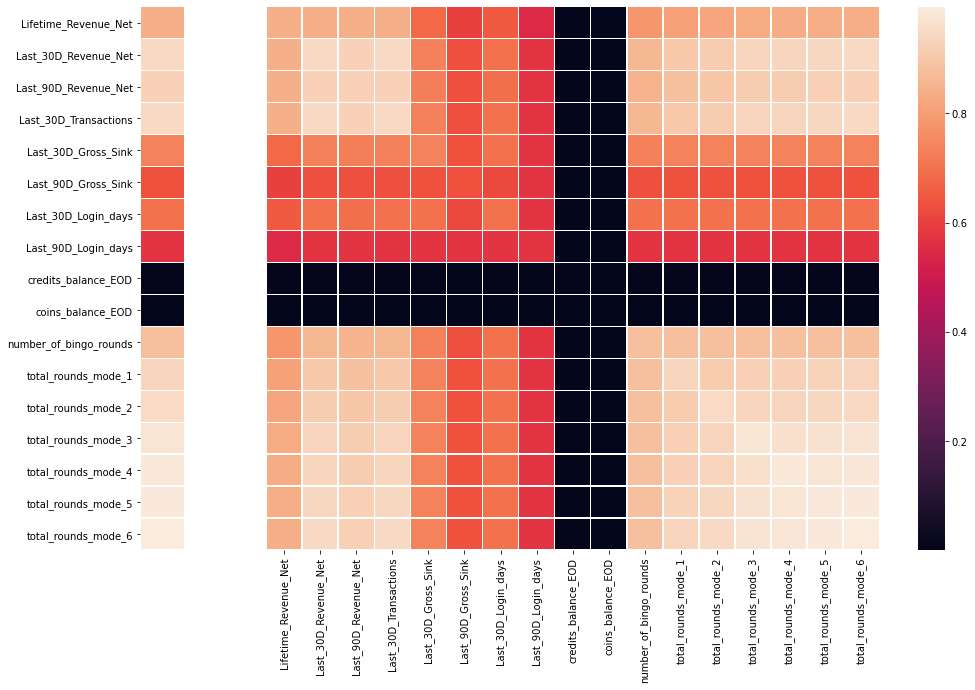

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 10), gridspec_kw={'width_ratios': [1, 17]})
sb.heatmap(zeros_asarray, linewidths=.5, cbar=False, yticklabels = columns_names, xticklabels = [], ax = ax1)
sb.heatmap(mat_zeros_overlap_count, linewidths=.5, xticklabels = columns_names, yticklabels = [], ax = ax2)
plt.show()

#### Overlapping Zeros - how many users with a zero value in one column also has a zero value in another column
1. The left subplot depicts the ratio of zeros in each column (number of zeros in the column / overall number of users). In most of these columns, the ratio is quite high. 
2. On the right is the ratio of overlapping zeros in any pair of columns (y-lables are as in left subplot) to the overall number of users. Almost all zeros are overlapping, and it is only bounded by the column with least zeros (that is, in the 'credit_balance_EOD' column there are only 590 zero values, while in the 'total_rounds_mode_6' almost all users have a zero value, and so the max number of users with zeros in both columns will be 590).  

The issue is relevant for the correlation section below. That is, if the zeros at both features the correlation is calculated for is because of the users behavior, then it is Ok. But if the zeros in one of the features is because of underlying reason that is not user-behavior related, then the correlation (that will stems from have co-occurances of zeros) will be meaningless. 

#### Paper about estimating correlations in the presence of zeros in the data

The paper "Performance of Some Correlation Coefficients When Applied to Zero-Clustered Data" (found [here](https://digitalcommons.wayne.edu/cgi/viewcontent.cgi?referer=&httpsredir=1&article=1101&context=jmasm)) discusses the impact of zeros on the estimation of the correlation coefficient by considering simulated data sets (created from different distributions) and different approaches for calculating the correlation.   
Main conclusion: They find that using Pearson and Spearman approaches leads to minor under-estimation of the actual correlation.  
To note, the ratio of zeros they tested were 0.1 to 0.3, while in our case, the ratio can be as high as 0.9 and above. 

## Correlations between the different features

- The estimations of the correlations considers the:
    - data type of a column (numerical, ordinal and nominal)
    - keeping or dropping the zeros
    - normality of the values (before and after the zeros are dropped) 
    - considering the recency of a user (e.g., deleting the users that are not relevant within an array -> the users with recency of more than 30 should be deleted from the array of 30D revenue). 

#### Pearson correlation
- To use the Pearson test, the data is required to be bi-variatly normal (that is, the data in each column is suppose to be normally distributed). 
- The data here is not normal for all features tested so far (see EDA Part 1 notebook), which is the reason that the Kendall test is used. 
- I am using the Kendall over the Spearman as it is suppose to be more powerful and better test overall. 

Comment about the **Spearman** correlation test: 
There is no requirement for the data to be normally distributed for the Spearman correlation. It is only required to be ordinal and the scores on one variable must be monotonically related to the other variable.

#### Kendall-tau correlation
Kendall's tau correlation coefficient is:
- A nonparametric measure of the strength and direction of association that exists between two variables measured on **at least an ordinal scale**. 
- It is considered a nonparametric alternative to the Pearson’s product-moment correlation when your data has failed one or more of the assumptions of this test (as in our case, the normality assumption). 
- It is also considered an alternative to the nonparametric Spearman rank-order correlation coefficient (especially when you have a small sample size with many tied ranks). 
- In our case, the data size is large, but still, from what I have found online it is suppose to be better to use than Spearman.

#### Point Bi-Serial correlation between the binary features and the remaining features
  
  
[Here](https://statistics.laerd.com/spss-tutorials/point-biserial-correlation-using-spss-statistics.php) is some explanation of the point bi-serial test.     
In particular, it **requires that**:
- The **continuous variable** should **be approximately normally distributed** for each category of the dichotomous variable. This can be tested using the **Shapiro-Wilk** test of normality.   
- The **continuous variable** have **equal variances** for each category of the dichotomous variable. This can be tested using **Levene's test** of equality of variances.
  
Importantly, and as always, if the requirements are not fulfilled, the results may not be valid. 

### To do 
   
- Add the tests for the Bi-Serial tests, and print the results from the function. 
- Still need to complete the case that one feature being nominal, and the other feature being numerical 
  or ordinal.

In [119]:
def calc_corr_and_significance(data, columns_math_data_types, recency_dependent_features, drop_zeros = True):
    
    """
    1. The correlations and their p-values between any two features in the data set is estimated. 
    
    2. Taken into account in the decision of which test to run is the data-type of the features (numerical, binary 
    ordinal, ordinal, and nominal), and whether or not they are normally distributed (for the cast of the numerical 
    features). 
    
    3. As the majority of the values for many of the features are 0, and as this may impact the correlations 
    coefficients and the p-values, there is the option (if the flag of drop_zeros is True) to also estimate the 
    correlations for pair features after their zeros-valued rows has been dropped. 
    
    4. Takes into account the recency, if it is relevant. 
    
    """
       
    results = {}
    results.update({'complete_data': {}})
    if drop_zeros:
        results.update({'zero_dropped_data': {}})
        
    correlations = np.zeros([data.shape[1], data.shape[1]])
    p_values = np.zeros([data.shape[1], data.shape[1]])
    
    if drop_zeros:
        correlations_zeros_dropped = np.zeros([data.shape[1], data.shape[1]])
        p_values_zeros_dropped = np.zeros([data.shape[1], data.shape[1]])
        
    # Estimating the normality of the numerical features
    normality = {}
    for column in data.columns:
        if columns_math_data_types[column] == 'Numerical':
                if column not in normality.keys():
                    normality.update({column: check_normality(data[column])})


    num_of_columns  = data.shape[1]
    # As the correlations matrix is symmetric, running over the upper triangle is sufficient. And then, 
    # the correlations matrix is filled accordingly. 
    total_runs = (num_of_columns)*(num_of_columns + 1)/2
    run_num = 0
    
    for ind_i in range(num_of_columns):
        column_i = data.columns[ind_i]
                
        for ind_j in range(ind_i, num_of_columns):
            column_j = data.columns[ind_j]
            
            if ind_i == ind_j: 
                print("Running auto-correlations on the {} feature.".format(column_i))
                
                correlations[ind_i][ind_j] = 1
                p_values[ind_i][ind_j] = 0
                
                if drop_zeros:
                    correlations_zeros_dropped[ind_i][ind_j] = 1
                    p_values_zeros_dropped[ind_i][ind_j] = 0
                    
                run_num += 1
                print('Finished {} out of {} correlation estimations.\n\n'.format(run_num, int(total_runs)))
                    
            else:
                print("Running correlations between {} and the {} features.".format(column_i, column_j))
                feature_pair = data[[column_i, column_j]]
                
                # Taking care of recency issue for some of the features
                if column_i in recency_dependent_features['30D'] or column_j in recency_dependent_features['30D']: 
                    print("Column {} or Column {} are in the 30D recency constraint".format(column_i, column_j))
                    feature_pair = feature_pair.drop(data[data.llrecency > 30].index) 
                
                elif column_i in recency_dependent_features['90D'] or column_j in recency_dependent_features['90D']:
                    print("Column {} or Column {} are in the 90D recency constraint".format(column_i, column_j))                    
                    feature_pair = feature_pair.drop(data[data.llrecency > 90].index)
                
                
                if columns_math_data_types[column_i] == 'Numerical' and columns_math_data_types[column_j] == 'Numerical':
                    print("Both features are numerical.")
                    if normality[column_i] == 'normal' and normality [column_j] == 'normal':
                        print('Running Pearson on full data')
                        r, p = stats.pearsonr(feature_pair[column_i], feature_pair[column_j])
                    else:
                        print('Running Kendall on full data')
                        r, p = stats.kendalltau(feature_pair[column_i], feature_pair[column_j])

                    if drop_zeros: 
                        # Preparing the zero-dropped data.
                        df_zeros_dropped = feature_pair[~(feature_pair == 0).any(axis=1)]
                    
                        if check_normality(df_zeros_dropped[column_i]) == 'normal' and check_normality(df_zeros_dropped[column_j]) == 'normal':
                            print('Running Pearson on zero dropped data')
                            r_zeros_dropped, p_zeros_dropped = stats.pearsonr(df_zeros_dropped[column_i], df_zeros_dropped[column_j])
                        else:
                            print('Running Kendall on zero dropped data')
                            r_zeros_dropped, p_zeros_dropped = stats.kendalltau(df_zeros_dropped[column_i], df_zeros_dropped[column_j])

                elif (columns_math_data_types[column_i] == 'Binary Ordinal' and columns_math_data_types[column_j] == 'Numerical') \
                        or \
                     (columns_math_data_types[column_i] == 'Numerical' and columns_math_data_types[column_j] == 'Binary Ordinal'):
                    
                    print("One of the features is binary-ordinal, and the other is numerical.")
                    
                    # Need to add test for normality for the numerical values in each category 
                    # Need to add the equal variance test
                    r, p = stats.pointbiserialr(feature_pair[column_i], feature_pair[column_j])
                    
                    if drop_zeros:
                        if columns_math_data_types[column_i] == 'Numerical':
                            df_zeros_dropped = feature_pair.drop(feature_pair[feature_pair.column_i == 0].index)
                        else:
                            df_zeros_dropped = feature_pair.drop(feature_pair[feature_pair.column_j == 0].index)
                            
                        # Need to add test for normality for the numerical values in each category 
                        # Need to add the equal variance test
                        r_zeros_dropped, p_zeros_dropped = stats.pointbiserialr(df_zeros_dropped[column_i], df_zeros_dropped[column_j]) 

                elif (columns_math_data_types[column_i] == 'Ordinal' and columns_math_data_types[column_j] in ['Numerical', 'Ordinal']) \
                        or \
                     (columns_math_data_types[column_i] in ['Numerical', 'Ordinal'] and columns_math_data_types[column_j] == 'Ordinal'):
                    
                    print("One of the features is ordinal, and the other is numerical or ordinal.")
                    
                    r, p = stats.kendalltau(feature_pair[column_i], feature_pair[column_j])
                    
                    if drop_zeros:
                        if columns_math_data_types[column_i] == 'Numerical':
                            df_zeros_dropped = feature_pair.drop(feature_pair[feature_pair.column_i == 0].index)
                            r_zeros_dropped, p_zeros_dropped = stats.pointbiserialr(df_zeros_dropped[column_i], df_zeros_dropped[column_j]) 
                        elif columns_math_data_types[column_j] == 'Numerical':
                            df_zeros_dropped = feature_pair.drop(feature_pair[feature_pair.column_j == 0].index)
                            r_zeros_dropped, p_zeros_dropped = stats.pointbiserialr(df_zeros_dropped[column_i], df_zeros_dropped[column_j])
                        else:
                            # For the case that both features are ordinal, to keep the zero-dropped matrix complete
                            # so adding the values found for the non-zero-dropped case
                            r_zeros_dropped, p_zeros_dropped = r, p
                
                # still need to complete the case of one feature being nominal, and the other feature being numerical 
                # or ordinal. 
                else:
                    
                    r, p = 0, 0.1
                    r_zeros_dropped, p_zeros_dropped = 0, 0.1


                if run_num%10 == 0: 
                    plot_scatter(feature_pair)
                    plot_scatter(df_zeros_dropped)
                
                run_num += 1
                print('Finished {} out of {} correlation estimations.\n\n'.format(run_num, int(total_runs)))

                correlations[ind_i][ind_j] = r
                correlations[ind_j][ind_i] = r  # using the symmetry of the correlations matrix
                p_values[ind_i][ind_j] = p
                p_values[ind_j][ind_i] = p      # using the symmetry of the p-values matrix
                if drop_zeros:
                    correlations_zeros_dropped[ind_i][ind_j] = r_zeros_dropped
                    correlations_zeros_dropped[ind_j][ind_i] = r_zeros_dropped
                    p_values_zeros_dropped[ind_i][ind_j] = p_zeros_dropped 
                    p_values_zeros_dropped[ind_j][ind_i] = p_zeros_dropped 
                    
                    
    results['complete_data'].update({'correlations': correlations})
    results['complete_data'].update({'p_values': p_values})
    
    if drop_zeros:
        results['zero_dropped_data'].update({'correlations': correlations_zeros_dropped})
        results['zero_dropped_data'].update({'p_values': p_values_zeros_dropped})
            
    return results

In [31]:
def check_normality(data):
    
    shapiro_test = stats.shapiro(data)
    if shapiro_test.pvalue <= 0.05:
        result = 'not-normal'
    else: 
        results = 'normal'
        
    return result

In [69]:
def plot_heat_map(data, xticklabels, yticklabels): 
    
    plt.figure(figsize = (16, 10))
    sb.heatmap(data, 
               linewidths=.5, 
               xticklabels = xticklabels, 
               yticklabels = yticklabels, 
               annot=True,  
               fmt = ".2f")
    plt.show()

In [113]:
def plot_scatter(data):
    
    plt.figure(figsize = (8, 6))
    sb.scatterplot(x = data.columns[0], 
                    y = data.columns[1], 
                    data = data)
    plt.show()

In [111]:
numerical_columns = [column for column in data_for_clustering.columns if column != 'dim_user_gid' and columns_math_data_types[column] == 'Numerical']
data_numerical = data_for_clustering[numerical_columns]
print(data_numerical.shape)
data_numerical.head()

(4985297, 20)


,level,llrecency,Lifetime_Revenue_Net,Last_30D_Revenue_Net,Last_90D_Revenue_Net,Last_30D_Transactions,Last_30D_Gross_Sink,Last_90D_Gross_Sink,Last_30D_Login_days,Last_90D_Login_days,credits_balance_EOD,coins_balance_EOD,number_of_bingo_rounds,Life_Time_Login_Days,total_rounds_mode_1,total_rounds_mode_2,total_rounds_mode_3,total_rounds_mode_4,total_rounds_mode_5,total_rounds_mode_6
23899,74.0,4,0.0000,0.0,0.000,0,42.0,42.0,2,2,23992.0,989739.0,0,72,0,0,0,0,0,0
40151,77.0,1,0.0000,0.0,0.000,0,0.0,0.0,6,17,591.0,129887.0,0,66,0,0,0,0,0,0
40152,97.0,1,0.0000,0.0,0.000,0,16952.0,53355.0,29,89,279.0,485502.0,10,136,0,0,5,0,0,0
40153,126.0,10,85.1555,0.0,10.493,0,0.0,2652.0,1,7,2278.0,2863137.0,0,306,0,0,0,0,0,0
68592,129.0,1,110.9604,0.0,10.493,0,450.0,25135.0,10,36,5698.0,1277645.0,0,307,0,0,0,0,0,0


Running auto-correlations on the level feature.
Finished 1 out of 210 correlation estimations.


Running correlations between level and the llrecency features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 2 out of 210 correlation estimations.


Running correlations between level and the Lifetime_Revenue_Net features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 3 out of 210 correlation estimations.


Running correlations between level and the Last_30D_Revenue_Net features.
Column level or Column Last_30D_Revenue_Net are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 4 out of 210 correlation estimations.


Running correlations between level and the Last_90D_Revenue_Net features.
Column level or Column Last_90D_Revenue_Net are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 5 out of 210 correlation estimations.


Running correlations between level and the Last_30D_Transactions features.
Column level or Column Last_30D_Transactions are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 6 out of 210 correlation estimations.


Running correlations between level and the Last_30D_Gross_Sink features.
Column level or Column Last_30D_Gross_Sink are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 7 out of 210 correlation estimations.


Running correlations between level and the Last_90D_Gross_Sink features.
Column level or Column Last_90D_Gross_Sink are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 8 out of 210 correlation estimations.


Running correlations between level and the Last_30D_Login_days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 9 out of 210 correlation estimations.


Running correlations between level and the Last_90D_Login_days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 10 out of 210 correlation estimations.


Running correlations between level and the credits_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


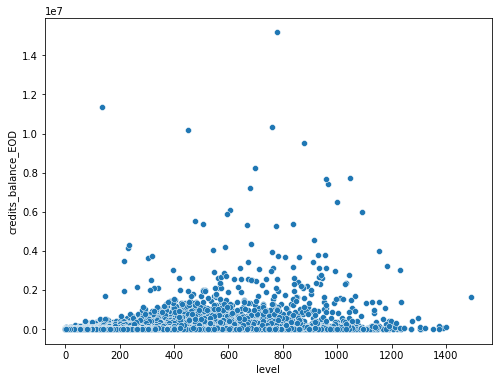

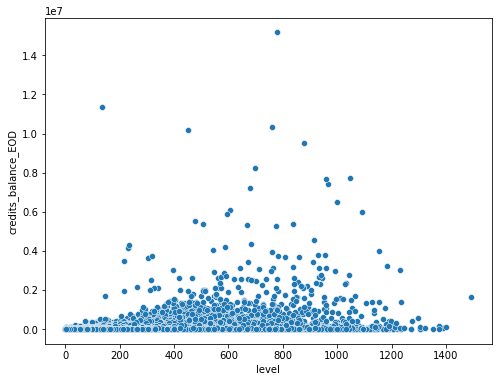

Finished 11 out of 210 correlation estimations.


Running correlations between level and the coins_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 12 out of 210 correlation estimations.


Running correlations between level and the number_of_bingo_rounds features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 13 out of 210 correlation estimations.


Running correlations between level and the Life_Time_Login_Days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 14 out of 210 correlation estimations.


Running correlations between level and the total_rounds_mode_1 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 15 out of 210 correlation estimations.


Running correlations between level and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 16 out of 210 correlation estimations.


Running correlations between level and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 17 out of 210 correlation estimations.


Running correlations between level and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 18 out of 210 correlation estimations.


Running correlations between level and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 19 out of 210 correlation estimations.


Running correlations between level and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 20 out of 210 correlation estimations.


Running auto-correlations on the llrecency feature.
Finished 21 out of 210 correlation estimations.


Running correlations between llrecency and the Lifetime_Revenue_Net features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 22 out of 210 correlation estimations.


Running correlations between llrecency and the Last_30D_Revenue_Net features.


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Column llrecency or Column Last_30D_Revenue_Net are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 23 out of 210 correlation estimations.


Running correlations between llrecency and the Last_90D_Revenue_Net features.
Column llrecency or Column Last_90D_Revenue_Net are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 24 out of 210 correlation estimations.


Running correlations between llrecency and the Last_30D_Transactions features.
Column llrecency or Column Last_30D_Transactions are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 25 out of 210 correlation estimations.


Running correlations between llrecency and the Last_30D_Gross_Sink features.
Column llrecency or Column Last_30D_Gross_Sink are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 26 out of 210 correlation estimations.


Running correlations between llrecency and the Last_90D_Gross_Sink features.
Column llrecency or Column Last_90D_Gross_Sink are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 27 out of 210 correlation estimations.


Running correlations between llrecency and the Last_30D_Login_days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 28 out of 210 correlation estimations.


Running correlations between llrecency and the Last_90D_Login_days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 29 out of 210 correlation estimations.


Running correlations between llrecency and the credits_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 30 out of 210 correlation estimations.


Running correlations between llrecency and the coins_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


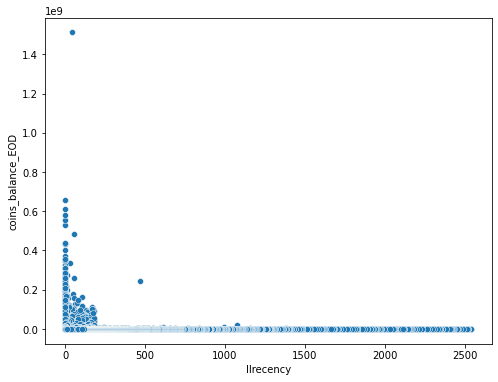

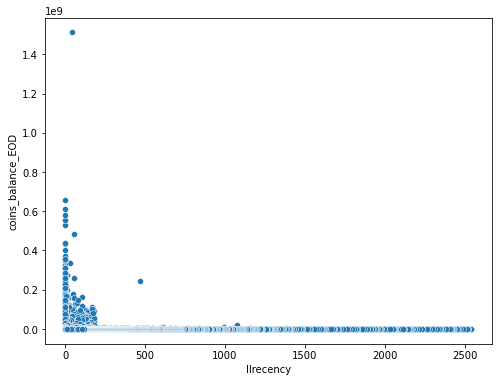

Finished 31 out of 210 correlation estimations.


Running correlations between llrecency and the number_of_bingo_rounds features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 32 out of 210 correlation estimations.


Running correlations between llrecency and the Life_Time_Login_Days features.


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 33 out of 210 correlation estimations.


Running correlations between llrecency and the total_rounds_mode_1 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 34 out of 210 correlation estimations.


Running correlations between llrecency and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 35 out of 210 correlation estimations.


Running correlations between llrecency and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 36 out of 210 correlation estimations.


Running correlations between llrecency and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 37 out of 210 correlation estimations.


Running correlations between llrecency and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 38 out of 210 correlation estimations.


Running correlations between llrecency and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 39 out of 210 correlation estimations.


Running auto-correlations on the Lifetime_Revenue_Net feature.
Finished 40 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the Last_30D_Revenue_Net features.
Column Lifetime_Revenue_Net or Column Last_30D_Revenue_Net are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


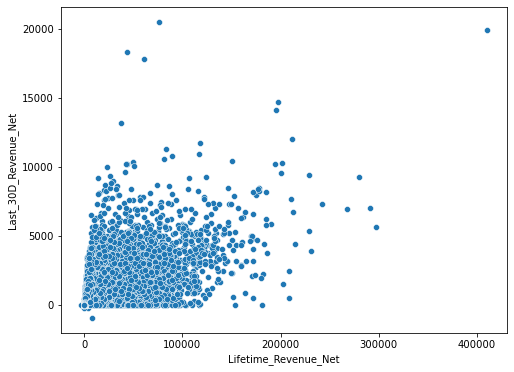

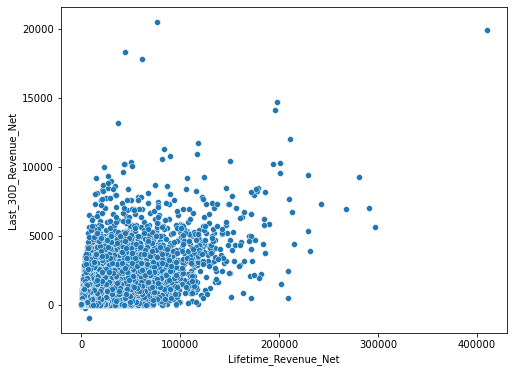

Finished 41 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the Last_90D_Revenue_Net features.
Column Lifetime_Revenue_Net or Column Last_90D_Revenue_Net are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 42 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the Last_30D_Transactions features.
Column Lifetime_Revenue_Net or Column Last_30D_Transactions are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 43 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the Last_30D_Gross_Sink features.
Column Lifetime_Revenue_Net or Column Last_30D_Gross_Sink are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 44 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the Last_90D_Gross_Sink features.
Column Lifetime_Revenue_Net or Column Last_90D_Gross_Sink are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 45 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the Last_30D_Login_days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 46 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the Last_90D_Login_days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 47 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the credits_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 48 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the coins_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 49 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the number_of_bingo_rounds features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 50 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the Life_Time_Login_Days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


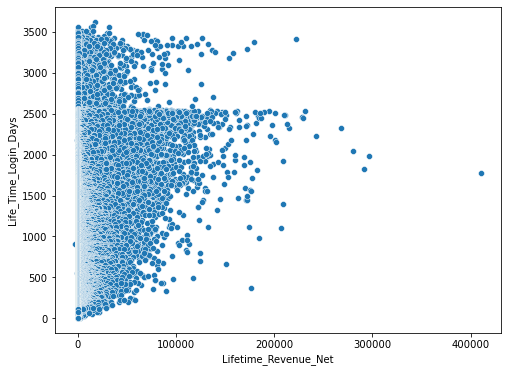

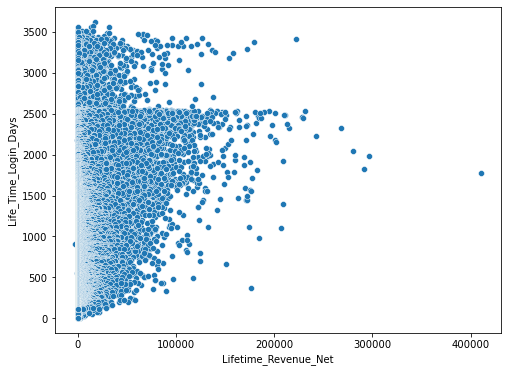

Finished 51 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the total_rounds_mode_1 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 52 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 53 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 54 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 55 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 56 out of 210 correlation estimations.


Running correlations between Lifetime_Revenue_Net and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 57 out of 210 correlation estimations.


Running auto-correlations on the Last_30D_Revenue_Net feature.
Finished 58 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the Last_90D_Revenue_Net features.
Column Last_30D_Revenue_Net or Column Last_90D_Revenue_Net are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 59 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the Last_30D_Transactions features.
Column Last_30D_Revenue_Net or Column Last_30D_Transactions are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 60 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the Last_30D_Gross_Sink features.
Column Last_30D_Revenue_Net or Column Last_30D_Gross_Sink are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


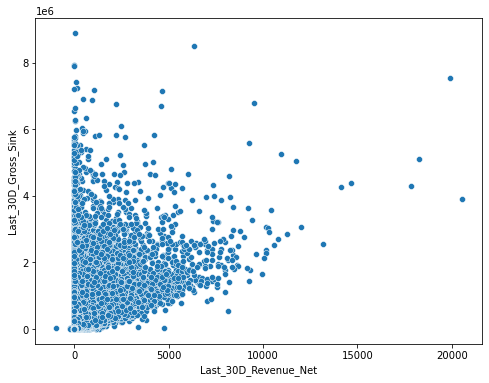

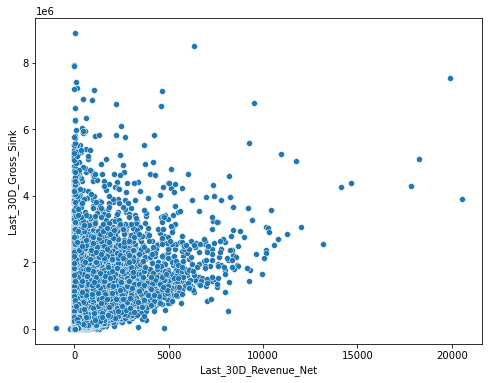

Finished 61 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the Last_90D_Gross_Sink features.
Column Last_30D_Revenue_Net or Column Last_90D_Gross_Sink are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 62 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the Last_30D_Login_days features.
Column Last_30D_Revenue_Net or Column Last_30D_Login_days are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 63 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the Last_90D_Login_days features.
Column Last_30D_Revenue_Net or Column Last_90D_Login_days are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 64 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the credits_balance_EOD features.
Column Last_30D_Revenue_Net or Column credits_balance_EOD are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 65 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the coins_balance_EOD features.
Column Last_30D_Revenue_Net or Column coins_balance_EOD are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 66 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the number_of_bingo_rounds features.
Column Last_30D_Revenue_Net or Column number_of_bingo_rounds are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 67 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the Life_Time_Login_Days features.
Column Last_30D_Revenue_Net or Column Life_Time_Login_Days are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 68 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the total_rounds_mode_1 features.
Column Last_30D_Revenue_Net or Column total_rounds_mode_1 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 69 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the total_rounds_mode_2 features.
Column Last_30D_Revenue_Net or Column total_rounds_mode_2 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 70 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the total_rounds_mode_3 features.
Column Last_30D_Revenue_Net or Column total_rounds_mode_3 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


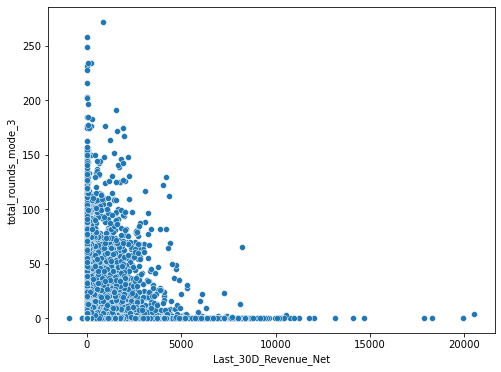

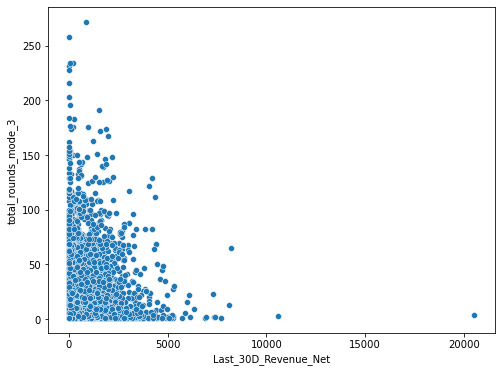

Finished 71 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the total_rounds_mode_4 features.
Column Last_30D_Revenue_Net or Column total_rounds_mode_4 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 72 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the total_rounds_mode_5 features.
Column Last_30D_Revenue_Net or Column total_rounds_mode_5 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 73 out of 210 correlation estimations.


Running correlations between Last_30D_Revenue_Net and the total_rounds_mode_6 features.
Column Last_30D_Revenue_Net or Column total_rounds_mode_6 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 74 out of 210 correlation estimations.


Running auto-correlations on the Last_90D_Revenue_Net feature.
Finished 75 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the Last_30D_Transactions features.
Column Last_90D_Revenue_Net or Column Last_30D_Transactions are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 76 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the Last_30D_Gross_Sink features.
Column Last_90D_Revenue_Net or Column Last_30D_Gross_Sink are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 77 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the Last_90D_Gross_Sink features.
Column Last_90D_Revenue_Net or Column Last_90D_Gross_Sink are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 78 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the Last_30D_Login_days features.
Column Last_90D_Revenue_Net or Column Last_30D_Login_days are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 79 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the Last_90D_Login_days features.
Column Last_90D_Revenue_Net or Column Last_90D_Login_days are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 80 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the credits_balance_EOD features.
Column Last_90D_Revenue_Net or Column credits_balance_EOD are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


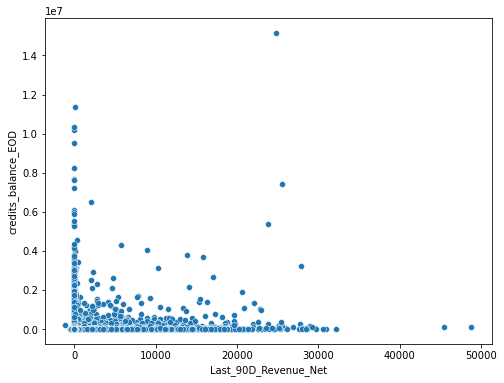

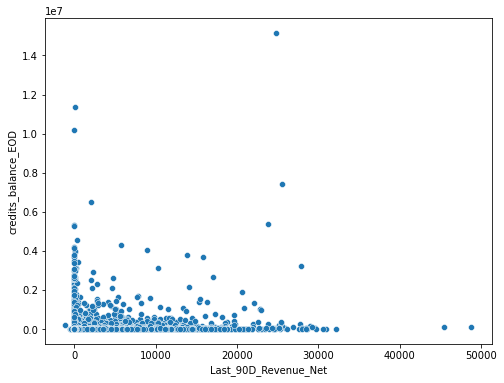

Finished 81 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the coins_balance_EOD features.
Column Last_90D_Revenue_Net or Column coins_balance_EOD are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 82 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the number_of_bingo_rounds features.
Column Last_90D_Revenue_Net or Column number_of_bingo_rounds are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 83 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the Life_Time_Login_Days features.
Column Last_90D_Revenue_Net or Column Life_Time_Login_Days are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 84 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the total_rounds_mode_1 features.
Column Last_90D_Revenue_Net or Column total_rounds_mode_1 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 85 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the total_rounds_mode_2 features.
Column Last_90D_Revenue_Net or Column total_rounds_mode_2 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 86 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the total_rounds_mode_3 features.
Column Last_90D_Revenue_Net or Column total_rounds_mode_3 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 87 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the total_rounds_mode_4 features.
Column Last_90D_Revenue_Net or Column total_rounds_mode_4 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 88 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the total_rounds_mode_5 features.
Column Last_90D_Revenue_Net or Column total_rounds_mode_5 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 89 out of 210 correlation estimations.


Running correlations between Last_90D_Revenue_Net and the total_rounds_mode_6 features.
Column Last_90D_Revenue_Net or Column total_rounds_mode_6 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 90 out of 210 correlation estimations.


Running auto-correlations on the Last_30D_Transactions feature.
Finished 91 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the Last_30D_Gross_Sink features.
Column Last_30D_Transactions or Column Last_30D_Gross_Sink are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 92 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the Last_90D_Gross_Sink features.
Column Last_30D_Transactions or Column Last_90D_Gross_Sink are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 93 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the Last_30D_Login_days features.
Column Last_30D_Transactions or Column Last_30D_Login_days are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 94 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the Last_90D_Login_days features.
Column Last_30D_Transactions or Column Last_90D_Login_days are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 95 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the credits_balance_EOD features.
Column Last_30D_Transactions or Column credits_balance_EOD are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 96 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the coins_balance_EOD features.
Column Last_30D_Transactions or Column coins_balance_EOD are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 97 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the number_of_bingo_rounds features.
Column Last_30D_Transactions or Column number_of_bingo_rounds are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 98 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the Life_Time_Login_Days features.
Column Last_30D_Transactions or Column Life_Time_Login_Days are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 99 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the total_rounds_mode_1 features.
Column Last_30D_Transactions or Column total_rounds_mode_1 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data
Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Finished 100 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the total_rounds_mode_2 features.
Column Last_30D_Transactions or Column total_rounds_mode_2 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data
Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


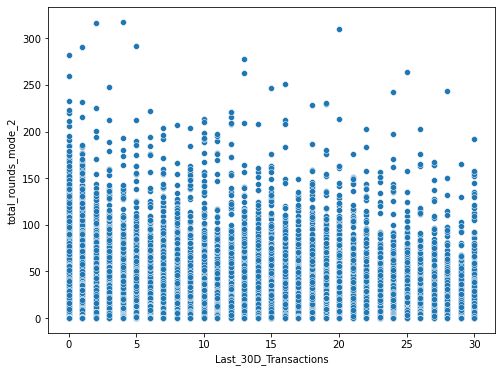

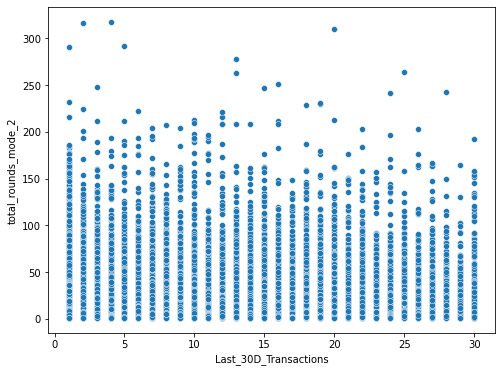

Finished 101 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the total_rounds_mode_3 features.
Column Last_30D_Transactions or Column total_rounds_mode_3 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data
Running Kendall on zero dropped data
Finished 102 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the total_rounds_mode_4 features.


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Column Last_30D_Transactions or Column total_rounds_mode_4 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data
Running Kendall on zero dropped data
Finished 103 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the total_rounds_mode_5 features.


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Column Last_30D_Transactions or Column total_rounds_mode_5 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data
Running Kendall on zero dropped data
Finished 104 out of 210 correlation estimations.


Running correlations between Last_30D_Transactions and the total_rounds_mode_6 features.


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Column Last_30D_Transactions or Column total_rounds_mode_6 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data
Running Kendall on zero dropped data
Finished 105 out of 210 correlation estimations.


Running auto-correlations on the Last_30D_Gross_Sink feature.
Finished 106 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the Last_90D_Gross_Sink features.


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Column Last_30D_Gross_Sink or Column Last_90D_Gross_Sink are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 107 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the Last_30D_Login_days features.
Column Last_30D_Gross_Sink or Column Last_30D_Login_days are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 108 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the Last_90D_Login_days features.
Column Last_30D_Gross_Sink or Column Last_90D_Login_days are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 109 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the credits_balance_EOD features.
Column Last_30D_Gross_Sink or Column credits_balance_EOD are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 110 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the coins_balance_EOD features.
Column Last_30D_Gross_Sink or Column coins_balance_EOD are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


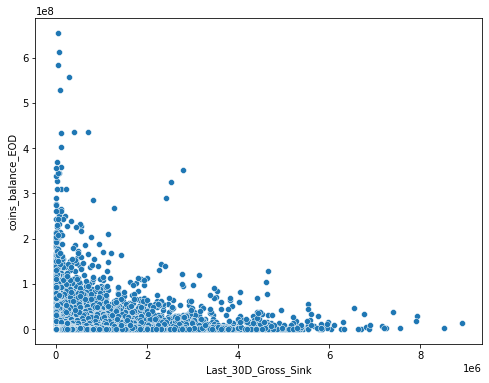

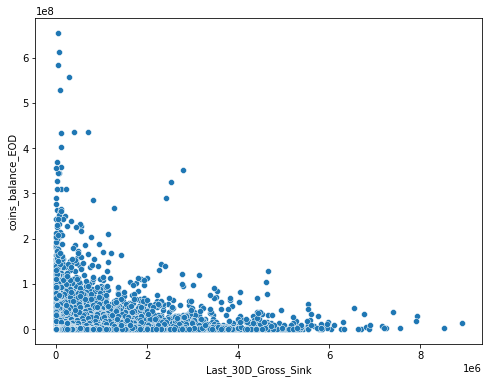

Finished 111 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the number_of_bingo_rounds features.
Column Last_30D_Gross_Sink or Column number_of_bingo_rounds are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 112 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the Life_Time_Login_Days features.
Column Last_30D_Gross_Sink or Column Life_Time_Login_Days are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 113 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the total_rounds_mode_1 features.
Column Last_30D_Gross_Sink or Column total_rounds_mode_1 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 114 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the total_rounds_mode_2 features.
Column Last_30D_Gross_Sink or Column total_rounds_mode_2 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 115 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the total_rounds_mode_3 features.
Column Last_30D_Gross_Sink or Column total_rounds_mode_3 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 116 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the total_rounds_mode_4 features.
Column Last_30D_Gross_Sink or Column total_rounds_mode_4 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 117 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the total_rounds_mode_5 features.
Column Last_30D_Gross_Sink or Column total_rounds_mode_5 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 118 out of 210 correlation estimations.


Running correlations between Last_30D_Gross_Sink and the total_rounds_mode_6 features.
Column Last_30D_Gross_Sink or Column total_rounds_mode_6 are in the 30D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 119 out of 210 correlation estimations.


Running auto-correlations on the Last_90D_Gross_Sink feature.
Finished 120 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the Last_30D_Login_days features.
Column Last_90D_Gross_Sink or Column Last_30D_Login_days are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


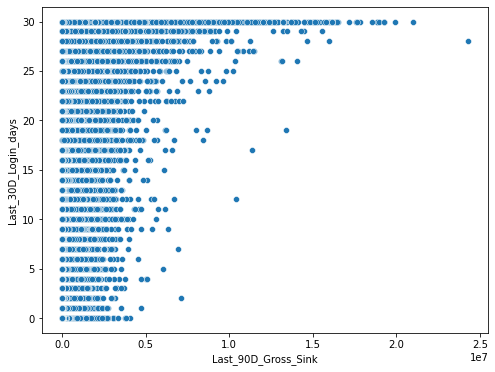

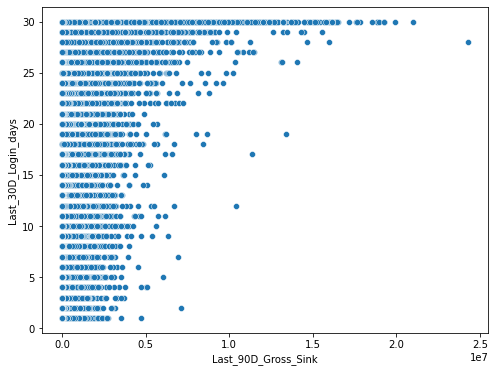

Finished 121 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the Last_90D_Login_days features.
Column Last_90D_Gross_Sink or Column Last_90D_Login_days are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 122 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the credits_balance_EOD features.
Column Last_90D_Gross_Sink or Column credits_balance_EOD are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 123 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the coins_balance_EOD features.
Column Last_90D_Gross_Sink or Column coins_balance_EOD are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 124 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the number_of_bingo_rounds features.
Column Last_90D_Gross_Sink or Column number_of_bingo_rounds are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 125 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the Life_Time_Login_Days features.
Column Last_90D_Gross_Sink or Column Life_Time_Login_Days are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 126 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the total_rounds_mode_1 features.
Column Last_90D_Gross_Sink or Column total_rounds_mode_1 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 127 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the total_rounds_mode_2 features.
Column Last_90D_Gross_Sink or Column total_rounds_mode_2 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 128 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the total_rounds_mode_3 features.
Column Last_90D_Gross_Sink or Column total_rounds_mode_3 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 129 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the total_rounds_mode_4 features.
Column Last_90D_Gross_Sink or Column total_rounds_mode_4 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 130 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the total_rounds_mode_5 features.
Column Last_90D_Gross_Sink or Column total_rounds_mode_5 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


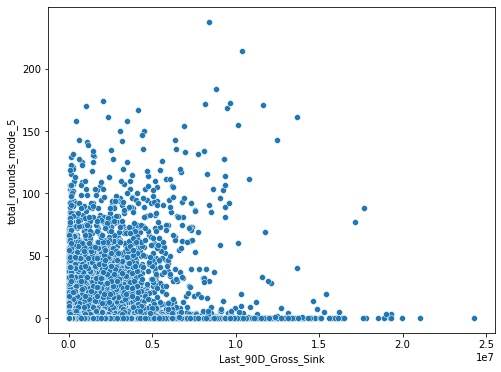

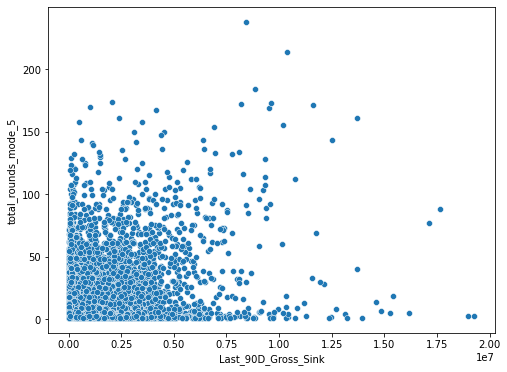

Finished 131 out of 210 correlation estimations.


Running correlations between Last_90D_Gross_Sink and the total_rounds_mode_6 features.
Column Last_90D_Gross_Sink or Column total_rounds_mode_6 are in the 90D recency constraint
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 132 out of 210 correlation estimations.


Running auto-correlations on the Last_30D_Login_days feature.
Finished 133 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the Last_90D_Login_days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 134 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the credits_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 135 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the coins_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 136 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the number_of_bingo_rounds features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 137 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the Life_Time_Login_Days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 138 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the total_rounds_mode_1 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 139 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 140 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


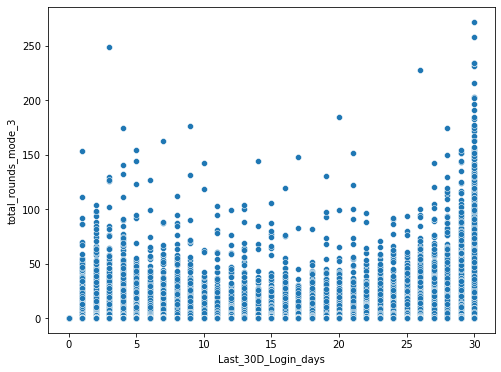

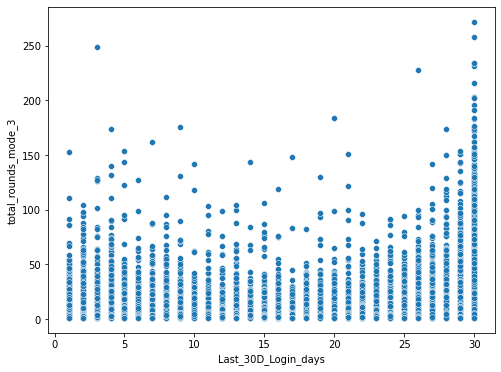

Finished 141 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 142 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 143 out of 210 correlation estimations.


Running correlations between Last_30D_Login_days and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 144 out of 210 correlation estimations.


Running auto-correlations on the Last_90D_Login_days feature.
Finished 145 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the credits_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 146 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the coins_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 147 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the number_of_bingo_rounds features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 148 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the Life_Time_Login_Days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 149 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the total_rounds_mode_1 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 150 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data


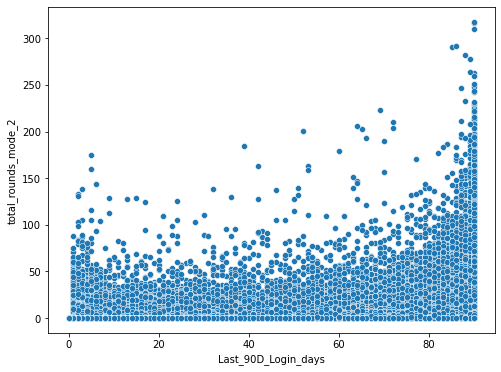

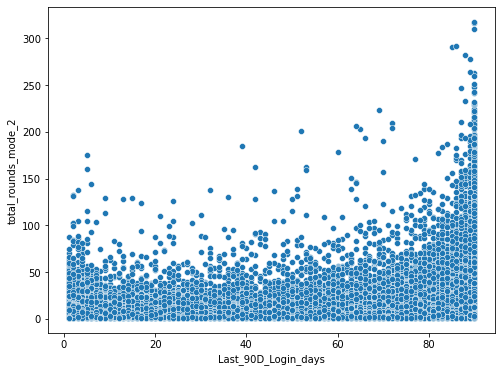

Finished 151 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 152 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 153 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 154 out of 210 correlation estimations.


Running correlations between Last_90D_Login_days and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 155 out of 210 correlation estimations.


Running auto-correlations on the credits_balance_EOD feature.
Finished 156 out of 210 correlation estimations.


Running correlations between credits_balance_EOD and the coins_balance_EOD features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 157 out of 210 correlation estimations.


Running correlations between credits_balance_EOD and the number_of_bingo_rounds features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 158 out of 210 correlation estimations.


Running correlations between credits_balance_EOD and the Life_Time_Login_Days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 159 out of 210 correlation estimations.


Running correlations between credits_balance_EOD and the total_rounds_mode_1 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 160 out of 210 correlation estimations.


Running correlations between credits_balance_EOD and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


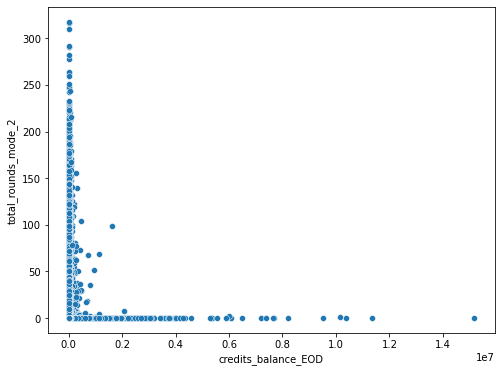

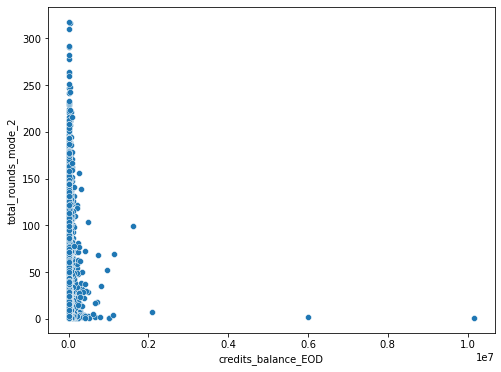

Finished 161 out of 210 correlation estimations.


Running correlations between credits_balance_EOD and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 162 out of 210 correlation estimations.


Running correlations between credits_balance_EOD and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 163 out of 210 correlation estimations.


Running correlations between credits_balance_EOD and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 164 out of 210 correlation estimations.


Running correlations between credits_balance_EOD and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 165 out of 210 correlation estimations.


Running auto-correlations on the coins_balance_EOD feature.
Finished 166 out of 210 correlation estimations.


Running correlations between coins_balance_EOD and the number_of_bingo_rounds features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 167 out of 210 correlation estimations.


Running correlations between coins_balance_EOD and the Life_Time_Login_Days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Finished 168 out of 210 correlation estimations.


Running correlations between coins_balance_EOD and the total_rounds_mode_1 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 169 out of 210 correlation estimations.


Running correlations between coins_balance_EOD and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 170 out of 210 correlation estimations.


Running correlations between coins_balance_EOD and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


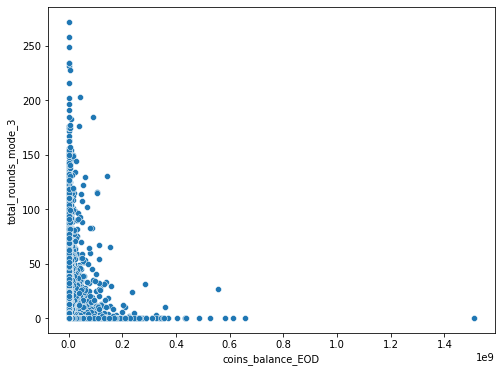

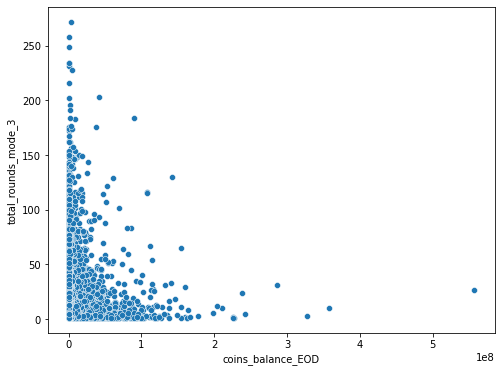

Finished 171 out of 210 correlation estimations.


Running correlations between coins_balance_EOD and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 172 out of 210 correlation estimations.


Running correlations between coins_balance_EOD and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 173 out of 210 correlation estimations.


Running correlations between coins_balance_EOD and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 174 out of 210 correlation estimations.


Running auto-correlations on the number_of_bingo_rounds feature.
Finished 175 out of 210 correlation estimations.


Running correlations between number_of_bingo_rounds and the Life_Time_Login_Days features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 176 out of 210 correlation estimations.


Running correlations between number_of_bingo_rounds and the total_rounds_mode_1 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 177 out of 210 correlation estimations.


Running correlations between number_of_bingo_rounds and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 178 out of 210 correlation estimations.


Running correlations between number_of_bingo_rounds and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 179 out of 210 correlation estimations.


Running correlations between number_of_bingo_rounds and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 180 out of 210 correlation estimations.


Running correlations between number_of_bingo_rounds and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


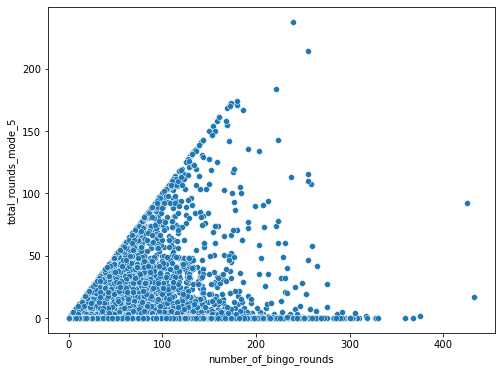

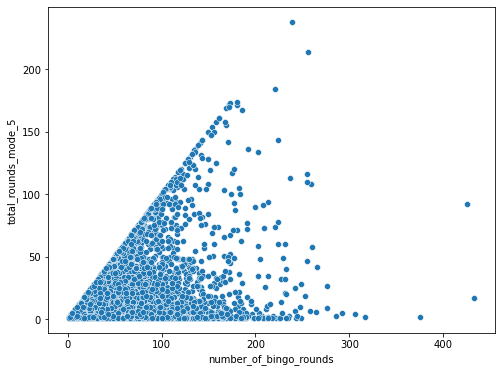

Finished 181 out of 210 correlation estimations.


Running correlations between number_of_bingo_rounds and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 182 out of 210 correlation estimations.


Running auto-correlations on the Life_Time_Login_Days feature.
Finished 183 out of 210 correlation estimations.


Running correlations between Life_Time_Login_Days and the total_rounds_mode_1 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 184 out of 210 correlation estimations.


Running correlations between Life_Time_Login_Days and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 185 out of 210 correlation estimations.


Running correlations between Life_Time_Login_Days and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 186 out of 210 correlation estimations.


Running correlations between Life_Time_Login_Days and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 187 out of 210 correlation estimations.


Running correlations between Life_Time_Login_Days and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 188 out of 210 correlation estimations.


Running correlations between Life_Time_Login_Days and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 189 out of 210 correlation estimations.


Running auto-correlations on the total_rounds_mode_1 feature.
Finished 190 out of 210 correlation estimations.


Running correlations between total_rounds_mode_1 and the total_rounds_mode_2 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data


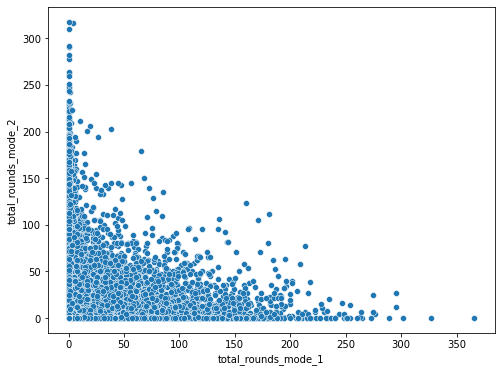

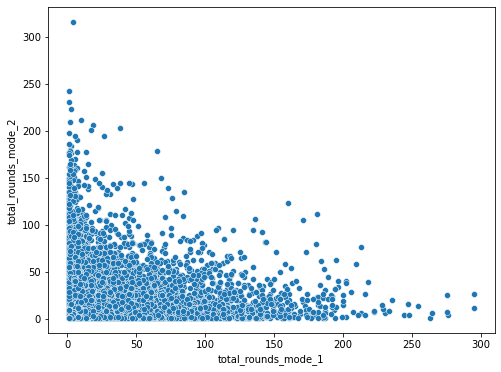

Finished 191 out of 210 correlation estimations.


Running correlations between total_rounds_mode_1 and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 192 out of 210 correlation estimations.


Running correlations between total_rounds_mode_1 and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 193 out of 210 correlation estimations.


Running correlations between total_rounds_mode_1 and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 194 out of 210 correlation estimations.


Running correlations between total_rounds_mode_1 and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Running Kendall on zero dropped data
Finished 195 out of 210 correlation estimations.


Running auto-correlations on the total_rounds_mode_2 feature.
Finished 196 out of 210 correlation estimations.


Running correlations between total_rounds_mode_2 and the total_rounds_mode_3 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 197 out of 210 correlation estimations.


Running correlations between total_rounds_mode_2 and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 198 out of 210 correlation estimations.


Running correlations between total_rounds_mode_2 and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 199 out of 210 correlation estimations.


Running correlations between total_rounds_mode_2 and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 200 out of 210 correlation estimations.


Running auto-correlations on the total_rounds_mode_3 feature.
Finished 201 out of 210 correlation estimations.


Running correlations between total_rounds_mode_3 and the total_rounds_mode_4 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 202 out of 210 correlation estimations.


Running correlations between total_rounds_mode_3 and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 203 out of 210 correlation estimations.


Running correlations between total_rounds_mode_3 and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 204 out of 210 correlation estimations.


Running auto-correlations on the total_rounds_mode_4 feature.
Finished 205 out of 210 correlation estimations.


Running correlations between total_rounds_mode_4 and the total_rounds_mode_5 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 206 out of 210 correlation estimations.


Running correlations between total_rounds_mode_4 and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data


/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Running Kendall on zero dropped data
Finished 207 out of 210 correlation estimations.


Running auto-correlations on the total_rounds_mode_5 feature.
Finished 208 out of 210 correlation estimations.


Running correlations between total_rounds_mode_5 and the total_rounds_mode_6 features.
Both features are numerical.
Running Kendall on full data
Running Kendall on zero dropped data
Finished 209 out of 210 correlation estimations.


Running auto-correlations on the total_rounds_mode_6 feature.
Finished 210 out of 210 correlation estimations.




/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4594: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/alexanderloe/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [120]:
results = calc_corr_and_significance(data_numerical, columns_math_data_types, recency_dependent_features)

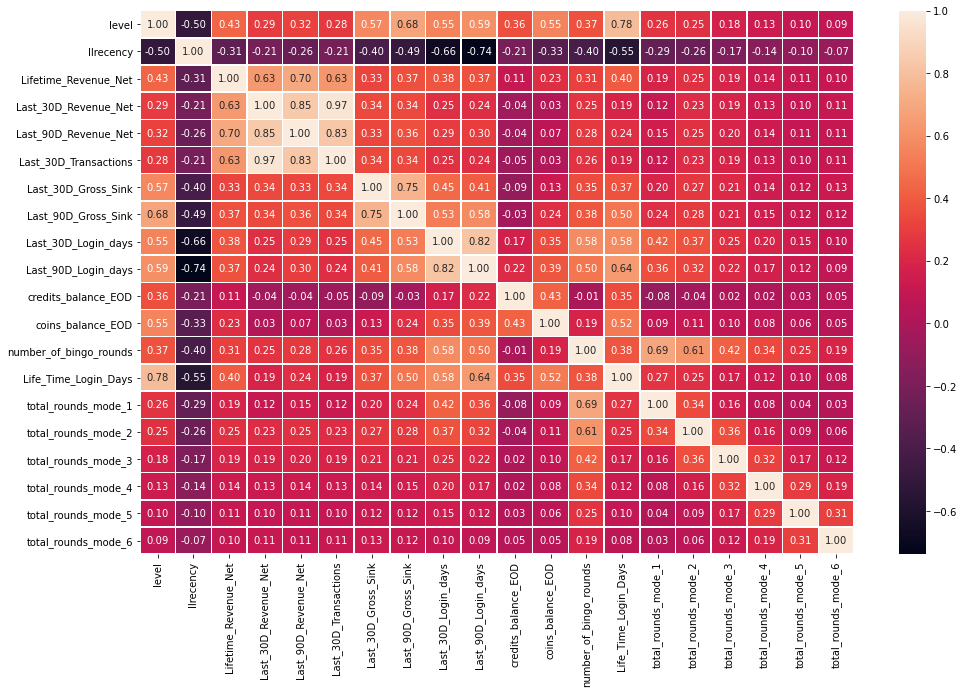

In [115]:
plot_heat_map(results['complete_data']['correlations'], numerical_columns, numerical_columns)

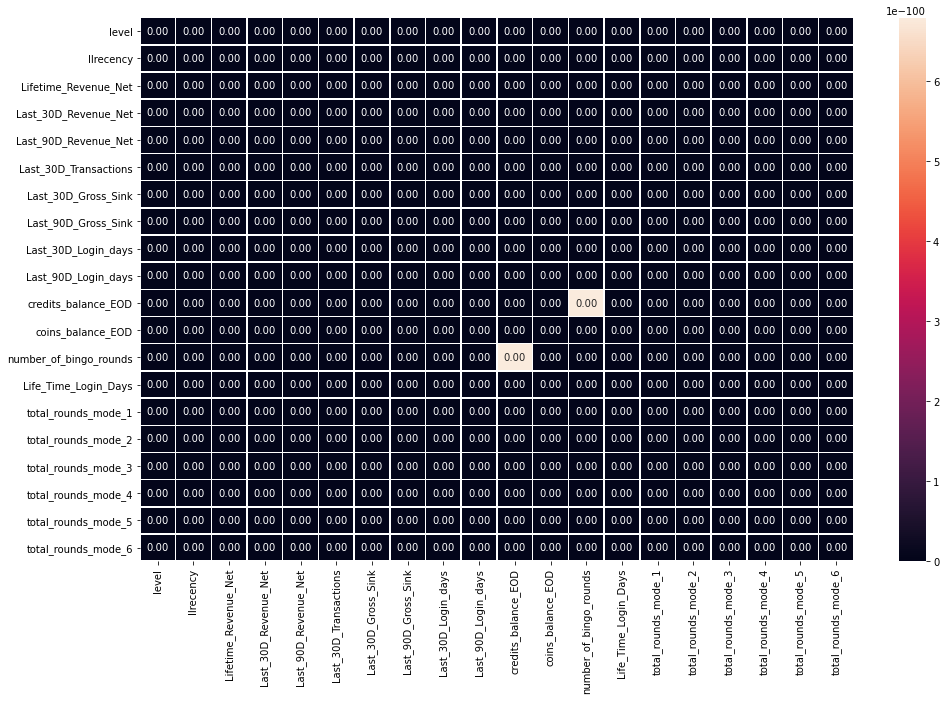

In [116]:
plot_heat_map(results['complete_data']['p_values'], numerical_columns, numerical_columns)

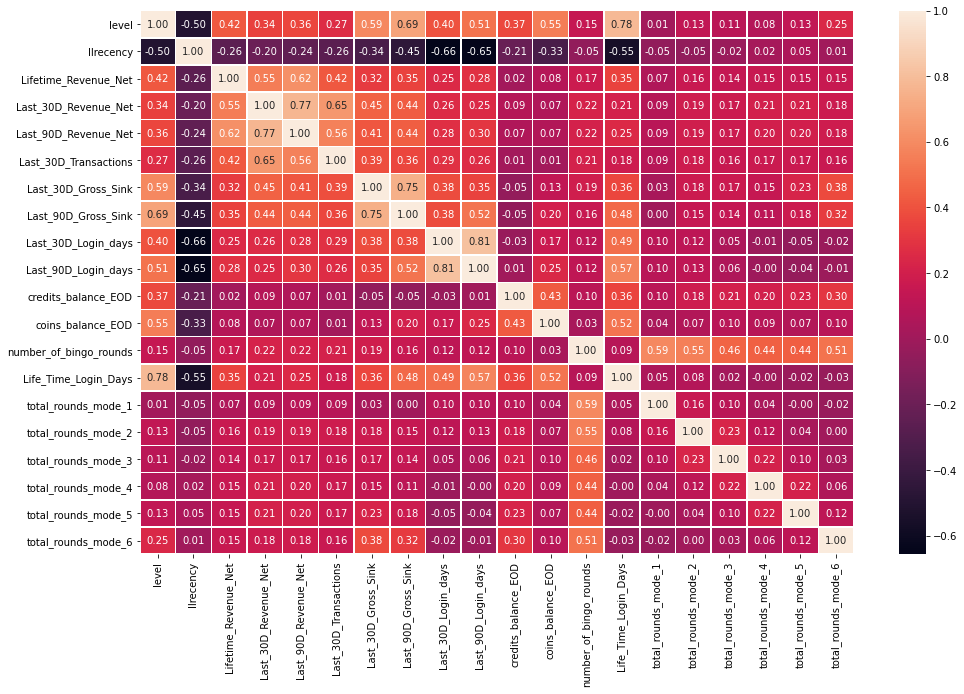

In [117]:
plot_heat_map(results['zero_dropped_data']['correlations'], numerical_columns, numerical_columns)

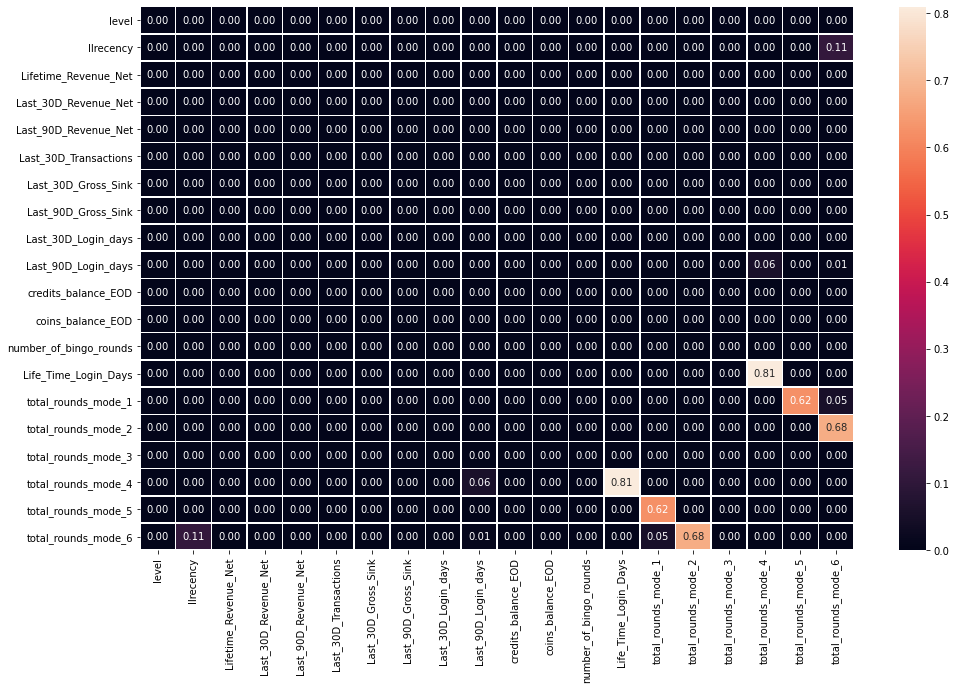

In [118]:
plot_heat_map(results['zero_dropped_data']['p_values'], numerical_columns, numerical_columns)

While the correlation between each two features may vary over quite a range, the majority of the features are significantly correlated. This is true for when the zeros of the data are included or dropped. This could be a result of wrongly using the significance tests (need to check this!), or because the data is indeed highly correlated. 

## Draft cells (used to build the above cells)

In [ ]:
# numerical_list = ['Lifetime_Revenue_Net', 'Last_30D_Revenue_Net', 'Last_90D_Revenue_Net', 'Last_30D_Gross_Sink', 'Last_90D_Gross_Sink', 'credits_balance_EOD', 'coins_balance_EOD']
# data_numerical = data_for_clustering[numerical_list]
# print(data_numerical.shape)
# data_numerical.head()

In [ ]:
# normality = {}
# for column in data_for_clustering.columns:
#     if column != 'dim_user_gid':
#         if columns_math_data_types[column] == 'Numerical':
#             result = check_normality(data_for_clustering[column])
#             normality.update({column: result})

In [ ]:
# # Choosing which correlation test to run for which pair of inputs
# tests = {}
# for column_i in data_numerical:
#     tests.update({column_i: {}})
#     for column_j in data_numerical:
#         if columns_math_data_types[column_i] == 'Numerical':
#             if columns_math_data_types[column_j] == 'Numerical':
#                 if normality[column_i] == 'normal' and normality [column_j] == 'normal':
#                     tests[column_i].update({column_j: 'Pearson'})
#                 else:
#                     tests[column_i].update({column_j: 'Kendall'})

# tests

### Cross-correlations between the continous features 

In [49]:
# cont_features = ['Lifetime_Revenue_Net', 'Last_30D_Revenue_Net', 'Last_90D_Revenue_Net', 'Last_30D_Gross_Sink', 'Last_90D_Gross_Sink', 'credits_balance_EOD', 'coins_balance_EOD']
# print("There are overall {} features with continous values. They are:.".format(len(cont_features)))
# for feat in cont_features:
#     print(feat)

In [50]:
# data_cont_features = data_for_clustering[cont_features]
# data_cont_features.shape
# data_cont_features.head()

In [51]:
# corr_pearson_cont_features = np.zeros([data_cont_features.shape[1], data_cont_features.shape[1]])
# p_value_pearson_cont_features = np.zeros([data_cont_features.shape[1], data_cont_features.shape[1]])

# for column_i in data_cont_features:
#     i = data_cont_features.columns.get_loc(column_i)
#     for column_j in data_cont_features:
#         j = data_cont_features.columns.get_loc(column_j)
#         r, p = stats.pearsonr(data_cont_features[column_i], data_cont_features[column_j])
#         corr_pearson_cont_features[i][j] = r
#         p_value_pearson_cont_features[i][j] = p

In [52]:
# plt.figure(figsize = (16, 10))
# sb.heatmap(corr_pearson_cont_features, 
#            linewidths=.5, 
#            xticklabels = cont_features, 
#            yticklabels = cont_features, 
#            annot=True,  
#            fmt = ".2f")
# plt.show()

In [53]:
# plt.figure(figsize = (16, 10))
# sb.heatmap(p_value_pearson_cont_features, 
#            linewidths=.5, 
#            xticklabels = cont_features, 
#            yticklabels = cont_features, 
#            annot=True,  
#            fmt = ".2f")
# plt.show()

In [54]:
# corr_spearman_cont_features = np.zeros([data_cont_features.shape[1], data_cont_features.shape[1]])
# p_value_spearman_cont_features = np.zeros([data_cont_features.shape[1], data_cont_features.shape[1]])

# for column_i in data_cont_features:
#     i = data_cont_features.columns.get_loc(column_i)
#     for column_j in data_cont_features:
#         j = data_cont_features.columns.get_loc(column_j)
#         r, p = stats.spearmanr(data_cont_features[column_i], data_cont_features[column_j])
#         corr_spearman_cont_features[i][j] = r
#         p_value_spearman_cont_features[i][j] = p

In [55]:
# plt.figure(figsize = (16, 10))
# sb.heatmap(corr_spearman_cont_features, 
#            linewidths=.5, 
#            xticklabels = cont_features, 
#            yticklabels = cont_features, 
#            annot=True,  
#            fmt = ".2f")
# plt.show()

In [56]:
# plt.figure(figsize = (16, 10))
# sb.heatmap(p_value_spearman_cont_features, 
#            linewidths=.5, 
#            xticklabels = cont_features, 
#            yticklabels = cont_features, 
#            annot=True,  
#            fmt = ".2f")
# plt.show()

In [57]:
# corr_kendall_cont_features = np.zeros([data_cont_features.shape[1], data_cont_features.shape[1]])
# p_value_kendall_cont_features = np.zeros([data_cont_features.shape[1], data_cont_features.shape[1]])

# for column_i in data_cont_features:
#     i = data_cont_features.columns.get_loc(column_i)
#     for column_j in data_cont_features:
#         j = data_cont_features.columns.get_loc(column_j)
#         r, p = stats.kendalltau(data_cont_features[column_i], data_cont_features[column_j])
#         corr_kendall_cont_features[i][j] = r
#         p_value_kendall_cont_features[i][j] = p

In [58]:
# plt.figure(figsize = (16, 10))
# sb.heatmap(corr_kendall_cont_features, 
#            linewidths=.5, 
#            xticklabels = cont_features, 
#            yticklabels = cont_features, 
#            annot=True,  
#            fmt = ".2f")
# plt.show()

In [59]:
# plt.figure(figsize = (16, 10))
# sb.heatmap(p_value_kendall_cont_features, 
#            linewidths=.5, 
#            xticklabels = cont_features, 
#            yticklabels = cont_features, 
#            annot=True,  
#            fmt = ".2f")
# plt.show()

In [ ]:
# # Testing the recency issue

# print(data_for_clustering['llrecency'][:15])

# column_i = 'Last_30D_Revenue_Net'
# column_j = 'Lifetime_Revenue_Net'

# feature_pair = data_for_clustering[[column_i, column_j]]
# print(feature_pair.shape)
# print(feature_pair.head(10))
                
# if column_i in recency_dependent_features['30D'] or column_j in recency_dependent_features['30D']: 
#     print("Column {} or Column {} are in the 30D recency constraint".format(column_i, column_j))
#     feature_pair = feature_pair.drop(data_for_clustering[data_for_clustering.llrecency > 30].index) 
#     print(feature_pair.shape)
#     print(feature_pair.head(10))

# elif column_i in recency_dependent_features['90D'] or column_j in recency_dependent_features['90D']:
#     print("Column {} or Column {} are in the 90D recency constraint".format(column_i, column_j))                    
#     feature_pair = feature_pair.drop(data_for_clustering[data_for_clustering.llrecency > 90].index)
#     print(feature_pair.shape)
#     print(feature_pair.head(10))

In [39]:
binary_features = ['is_elite', 'is_vip']
for_bi_serieal_features = cont_features + ['level', 'trstier', 'Last_30D_Transactions', 'Last_30D_Login_days', 'Last_90D_Login_days', 'number_of_bingo_rounds', 'Life_Time_Login_Days', 'total_rounds_mode_1', 'total_rounds_mode_6' ]

print(for_bi_serieal_features)

['Lifetime_Revenue_Net', 'Last_30D_Revenue_Net', 'Last_90D_Revenue_Net', 'Last_30D_Gross_Sink', 'Last_90D_Gross_Sink', 'credits_balance_EOD', 'coins_balance_EOD', 'level', 'trstier', 'Last_30D_Transactions', 'Last_30D_Login_days', 'Last_90D_Login_days', 'number_of_bingo_rounds', 'Life_Time_Login_Days', 'total_rounds_mode_1', 'total_rounds_mode_6']


In [42]:
data_binary_features = data_for_clustering[binary_features]
data_for_bi_serial_features = data_for_clustering[for_bi_serieal_features]
print(data_binary_features.shape)
print(data_for_bi_serial_features.shape)

(4985297, 2)
(4985297, 16)


In [44]:
corr_bi_serial = np.zeros([data_binary_features.shape[1], data_for_bi_serial_features.shape[1]])
p_value_bi_serial = np.zeros([data_binary_features.shape[1], data_for_bi_serial_features.shape[1]])

for column_i in data_binary_features:
    i = data_binary_features.columns.get_loc(column_i)
    for column_j in data_for_bi_serial_features:
        j = data_for_bi_serial_features.columns.get_loc(column_j)
        r, p = stats.pointbiserialr(data_binary_features[column_i], data_for_bi_serial_features[column_j])
        corr_bi_serial[i][j] = r
        p_value_bi_serial[i][j] = p

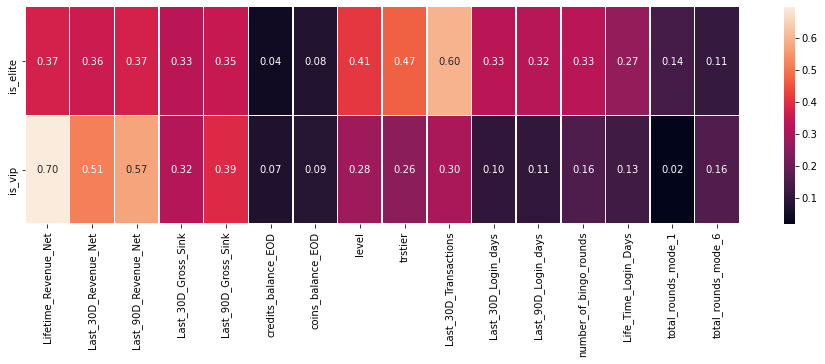

In [47]:
plt.figure(figsize = (16, 4))
sb.heatmap(corr_bi_serial, 
           linewidths=.5, 
           xticklabels = for_bi_serieal_features, 
           yticklabels = binary_features, 
           annot=True,  
           fmt = ".2f")
plt.show()

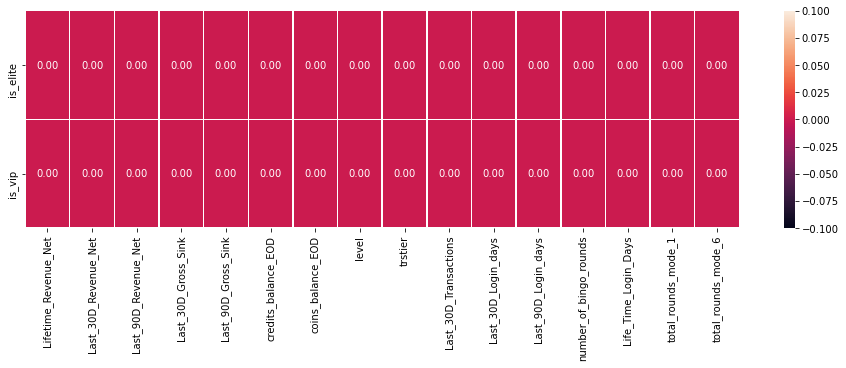

In [48]:
plt.figure(figsize = (16, 4))
sb.heatmap(p_value_bi_serial, 
           linewidths=.5, 
           xticklabels = for_bi_serieal_features, 
           yticklabels = binary_features, 
           annot=True,  
           fmt = ".2f")
plt.show()

The range of the Point Bi-Serial correlations between the binary 'is_elite' and 'is_vip' can be as high as 0.7 (vip status and life time revenue, which of course make sense), and as low as 0.02 (vip status and total rounds mode 1).  
Still, the correlations are significant for all relations. Here as well, I suspect that this is the case because of the large co-occurances of zeros in each column pair. 